# SD-TSIA211 - Optimization for Machine Learning : Computer lab 1
## Gabriel Medeiros and Júlia Togashi

In [1]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.optimize import check_grad
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
def load_movielens(filename, minidata=False):
    """
    Cette fonction lit le fichier filename de la base de donnees
    Movielens, par exemple 
    filename = '~/datasets/ml-100k/u.data'
    Elle retourne 
    R : une matrice utilisateur-item contenant les scores
    mask : une matrice valant 1 si il y a un score et 0 sinon
    """

    data = np.loadtxt(filename, dtype=int)

    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),
                          dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape),
                              (data[:, 0]-1, data[:, 1]-1)), dtype=bool )
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask


def objective(P, Q0, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q0 : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    """

    tmp = (R - Q0.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))

    grad_P = - Q0.T.dot(tmp) + rho*P

    return val, grad_P


def total_objective(P, Q, R, mask, rho):
    """
    La fonction objectif du probleme complet.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q : la variable matricielle de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))

    grad_P = - Q.T.dot(tmp) + rho*P

    grad_Q = - tmp.dot(P.T) + rho*Q

    return val, grad_P, grad_Q


def total_objective_vectorized(PQvec, R, mask, rho):
    """
    Vectorisation de la fonction precedente de maniere a ne pas
    recoder la fonction gradient
    """

    # reconstruction de P et Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = PQvec.shape[0] // (n_items + n_users)
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))

    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, np.concatenate([grad_P.ravel(), grad_Q.ravel()])


### 1.1
Yes. The R matrix's dimensions are 943 x 1682.

The minidata option, when True, returns a reduced sample of both R and mask, containing only the first 100 rows and 200 columns as opposed to the entire 943x1682.

In [3]:
#R: User X Movie
#Mask: indicates if in R's corresponding position there is a valid rating
R, mask = load_movielens('ml-100k/u.data')
print(np.shape(R))

(943, 1682)


In [5]:
R_m, mask_m = load_movielens('ml-100k/u.data',minidata=True)
print(np.shape(R_m))

(100, 200)


### 1.2

The number of users corresponds to the number of rows and the number of movies to the number of columns:

In [6]:
print(f'The number of users is: {np.shape(R)[0]}')
print(f'The number of movies is: {np.shape(R)[1]}')
print(f'The number of grades is: {np.count_nonzero(mask)}')

The number of users is: 943
The number of movies is: 1682
The number of grades is: 100000


### 2.1

In [4]:
u, s, vt = svds(R)
print(np.shape(s))
# As F = {0; 1; 2; 3}, so Q0 is equal to the left singular vectors of R assossiated with the 4 largest singular values.
# u => Unitary matrix having left singular vectors as columns.
Q0 = u[:, 2:6].copy()
print(f'Qs dimensions: {np.shape(Q0)}')
P0 = vt[2:6,:].copy()
print(f'Ps dimensions: {np.shape(P0)}')
print(f'R and 1s dimensions: {np.shape(R)}')

(6,)
Qs dimensions: (943, 4)
Ps dimensions: (4, 1682)
R and 1s dimensions: (943, 1682)


The function g in equal to:
$$g(P)=\frac{1}{2} ||1_K \circ(R-Q^0P)||^2_F + \frac{\rho}{2}||Q^0||^2_F+\frac{\rho}{2}||P||^2_F$$

Thus, we have the gradient of g:

$$\nabla g(P)= - (Q^0)^T (1_K \circ(R-Q^0P)) + \rho (P)$$
 
R => |U| x |I|

Q => |U| x |F|

P => |F| x |I|

1<sub>k</sub> => |U| x |I|

So, it can be verified that the matrixes are the right size for the gradient operations.

<br>
<br>
Furthermore, the gradient of g is Lipschitz continuous, which means:

$$||\nabla g(x) - \nabla g(y)|| \le L||x-y||$$

$$ L_0 = \gamma + ||(Q^0)^TQ^0||_F$$

$$||\nabla g(x) - \nabla g(y)|| \le \gamma + ||(Q^0)^TQ^0||_F ||x-y||$$



### 2.2

The updated objective function used for the gradient's calculation can be found above.

Below, is the result check using the function scipy.optimize.check grad. Function G and gradient of G were re-implemented because the scypy method doesn’t accept matrixes as entries.  

The result is equivalent to the 2-norm of the difference between the computed gradient and the finite difference approximation of grad using func at the points x0. The result equal to one seems reasonable with a good result.


In [5]:
val, grad_P = objective(P0, Q0, R, mask, 0.3)
print(val,"\n\n",grad_P,"\n\n", np.linalg.norm(grad_P))

685091.7826478565 

 [[-2.55511347e+00 -5.13441086e-01 -7.73878335e+00 ...  1.51419184e-01
  -1.22846636e-02 -2.77930288e-01]
 [-3.66873174e+00 -1.35718942e+01 -2.52859733e+00 ...  1.15949951e-01
  -9.88378905e-02 -5.68629500e-02]
 [ 2.12714964e+01  1.71114543e+00  6.98904993e+00 ...  1.09578207e-01
  -2.57325476e-02 -4.96748331e-02]
 [ 6.13606989e+01  2.24992343e+01  1.27481888e+01 ...  1.94487024e-02
   2.11983433e-01  2.02878594e-01]] 

 735.422317970695


In [201]:
def g(P,Q0, R,mask,rho):
    P=np.reshape(P,(4,1682))
    Q0= np.reshape(Q0,(943,4))
    R= np.reshape(R,(943,1682))
    mask= np.reshape(mask,(943,1682))
    
    tmp = (R - Q0.dot(P)) * mask
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))
    return val
    
def grad_g(P,Q0, R,mask,rho):
    P=np.reshape(P,(4,1682))
    Q0= np.reshape(Q0,(943,4))
    R= np.reshape(R,(943,1682))
    mask= np.reshape(mask,(943,1682))
    
    tmp = (R - Q0.dot(P)) * mask
    grad_P = - Q0.T.dot(tmp) + rho*P
    return np.ravel(grad_P)

check = check_grad(g,grad_g,np.ravel(P0),np.ravel(Q0),np.ravel(R),np.ravel(mask),0.3)
print(check)

1.1535664527828076


### 2.3

The function below, guarantees convergence of the gradient descent method when $0<\gamma<2/L $, where L was previously defined in 2.1:

In [6]:
#gradient descent implemented in a generic way
def gradient(g,grad_g, P0, gamma, epsilon):
    P=P0
    while np.linalg.norm(grad_g(P),'fro')>epsilon:
        #print(g(P))
        P=P-(gamma*grad_g(P))
    return g(P),P

### 2.4

Using the function implemented in the previously with $ \epsilon = 1$, and with $\gamma$ defined to guarantee  convergence as stated in 2.3.

In [8]:
gamma=1/(np.linalg.norm(Q0.T.dot(Q0),'fro') + 0.3)

val,P=gradient(lambda P0:objective(P0,Q0,R,mask,0.3)[0],lambda P0:objective(P0,Q0,R,mask,0.3)[1], P0, gamma, 1)
print(val)

369551.54991481936


### 2.5

Line search can be used when the Lipschitz constant L is unknown, or when the gradient the function's gradient is only locally Lipschitz continuous. Using the gradient method's proof, $\gamma$ can be estimated:

$$x^+(\gamma_k)=x_k-\gamma_k\nabla f(x_k)$$

For a $b>0$ and $a\in(0,1)$, search for the first non-negative integer I, such that $\nabla={ba}^I$:

$$f(X^+(ba^I))\leq f(x_k) + <\nabla f(x_k),x^+(ba^I) - x_k> + \frac{1}{2{ba}^I}||x_k-x^+(ba^I)||^2$$

Classical parameter choices are $a = 0.5$ and $b =2\gamma_{k-1}$and for the gradient descent method $<\nabla f(x_k),x^+(\gamma) - x_k> = -\gamma||\nabla f(x_k)||^2$.

As can be seen below, the gradient method's result using line search was close to the result when the Lipschitz constant was known beforehand.

In [244]:
#gradient descent implemented using line search in a generic way
def gradient_line_search(g,grad_g, P0,a, b, epsilon):
    P=P0
    aux= []
    aux_g=[]
    if (b<=0 or a<=0 or a>=1):
        return("b should be >0 and a should be in the interval (0,1)")
    aux.append(np.linalg.norm(grad_g(P),'fro'))
    aux_g.append(g(P))
    while np.linalg.norm(grad_g(P),'fro')>epsilon:
        I=0
        gamma=b*(a**I)
        P_plus=P-(gamma*grad_g(P))
        while(g(P_plus)>g(P)-gamma*np.sum(grad_g(P)**2)+(1/(2*gamma))*(np.sum((P-P_plus) ** 2))):
            I+=1
            gamma=b*(a**I)
            P_plus=P-(gamma*grad_g(P))
        P=P-(gamma*grad_g(P))
        b=2*gamma
        aux.append(np.linalg.norm(grad_g(P),'fro'))
        aux_g.append(g(P))
    return g(P),P, aux, aux_g

369551.01407482446


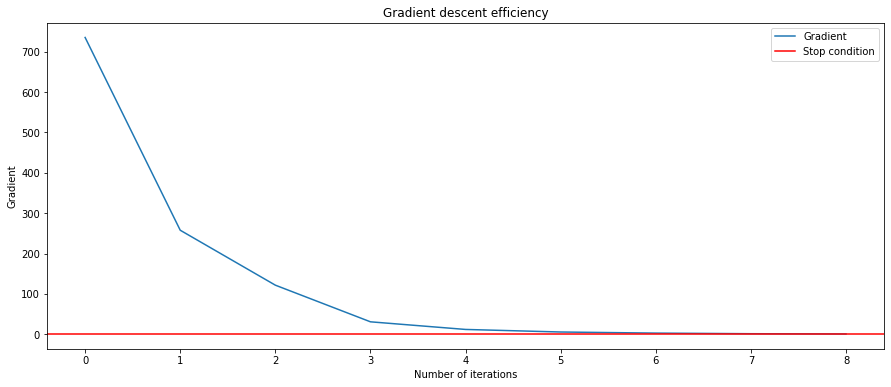

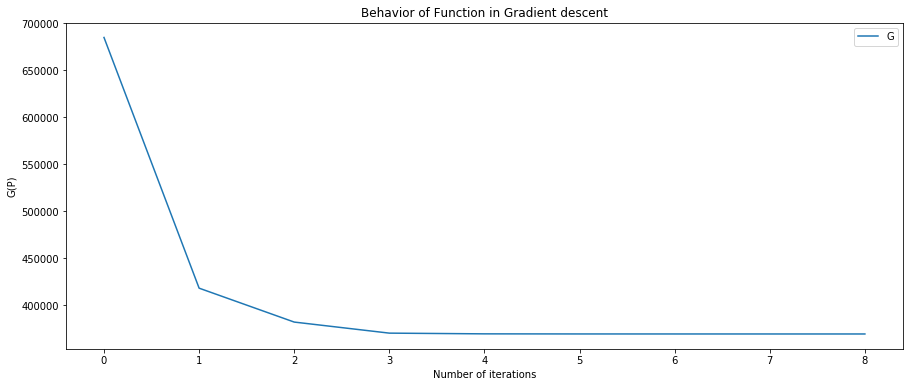

In [273]:
gls,P, vec,vec_g =  gradient_line_search(lambda P0:objective(P0,Q0,R,mask,0.3)[0],lambda P0:objective(P0,Q0,R,mask,0.3)[1], P0, 0.5,3, 1)
print(gls)

plt.figure(figsize=(15, 6))

plt.plot(vec, label = 'Gradient')
plt.axhline(y=1, color='r', label = 'Stop condition')
plt.title('Gradient descent efficiency')
plt.xlabel('Number of iterations')
plt.ylabel('Gradient')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(vec_g, label = 'G')
plt.title('Behavior of Function in Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('G(P)')
plt.legend()
plt.show()

### 3.1

Assuming it is Lipschitz continuous:
$$||\nabla f(x, y) - \nabla f(x_1, y)|| \leq K ||x - x_1||$$

Then:
$$\Bigl| \Bigl| \frac{\nabla f(x, y) - \nabla f(x_1, y)}{x - x_1} \Bigr | \Bigr | \leq K$$

However, when $x \rightarrow x_1$:
$$\Bigl| \Bigl| \frac{\nabla f(x, y) - \nabla f(x_1, y)}{x - x_1} \Bigr | \Bigr | \rightarrow \frac{\partial \nabla f(x_1, y)}{\partial x}$$

Therefore:
$$\Bigl| \Bigl| \frac{\partial \nabla f(x, y)}{\partial x} \Bigr | \Bigr | \leq K$$

But $\frac{\partial \nabla f(x_1, y)}{\partial x}$ is a polynomial of degree 2 which is unbounded, so the statement above is impossible. Therefore it can't be Lipschitz continuous

### 3.2

From 2.1 it is known that:
$$\frac{\partial g(P, Q)}{\partial P}= - (Q)^T (1_K \circ(R-QP)) + \rho (P)$$

Repeating the same process for P:
$$\frac{\partial g(P, Q)}{\partial Q}= - (1_K \circ(R-QP)) (P)^T + \rho (Q)$$

These functions were added to the total_objective function

In [9]:
def total_gradLS (total_objective, P, Q, R, mask, rho, a, b, epsilon):
    if (b<=0 or a<=0 or a>=1):
        return("b should be >0 and a should be in the interval (0,1)")
    val, gradP, gradQ = total_objective(P, Q, R, mask, rho)
    aux = []
    aux_g = []
    aux.append(np.linalg.norm(gradP,'fro') + np.linalg.norm(gradQ,'fro'))
    aux_g.append(val)
    while np.linalg.norm(gradP,'fro') + np.linalg.norm(gradQ,'fro')>epsilon:

        I=0
        gamma=b*(a**I)
        Pplus=P-(gamma*gradP)
        Qplus=Q-(gamma*gradQ)


        #finding the gamma constant
        valPlus, _, _ = total_objective(Pplus, Qplus, R, mask, rho)
        while(valPlus>val-gamma*(np.sum(gradP**2)+np.sum(gradQ**2))+(1/(2*gamma))*(np.sum((P-Pplus)**2)+np.sum((Q-Qplus)**2))):
            I+=1
            gamma=b*(a**I)
            Pplus=P-(gamma*gradP)
            Qplus=Q-(gamma*gradQ)
            valPlus, _, _ = total_objective(Pplus, Qplus, R, mask, rho)

        P = P - gamma*gradP
        Q = Q - gamma*gradQ
        b=2*gamma
        val, gradP, gradQ = total_objective(P, Q, R, mask, rho)
        aux.append(np.linalg.norm(gradP,'fro') + np.linalg.norm(gradQ,'fro'))
        aux_g.append(val)
    return val, P, Q, aux,aux_g

In [10]:
val, P, Q, vecpq,vecg = total_gradLS(total_objective, P0, Q0, R, mask, 0.3, 0.5, 3, 100)
print(val)

35547.55724736608


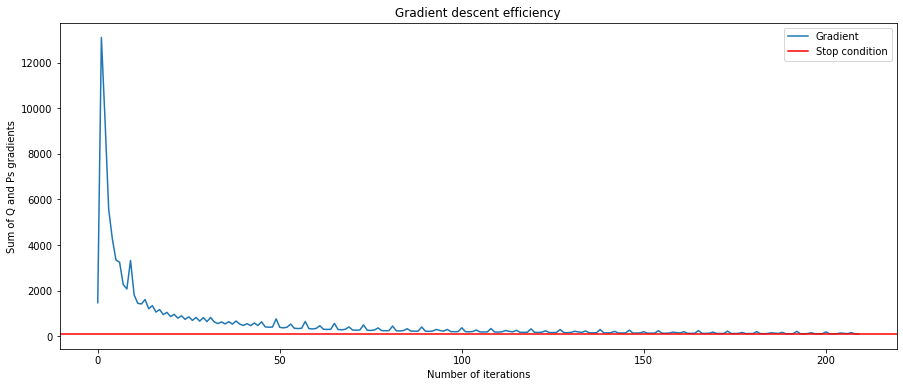

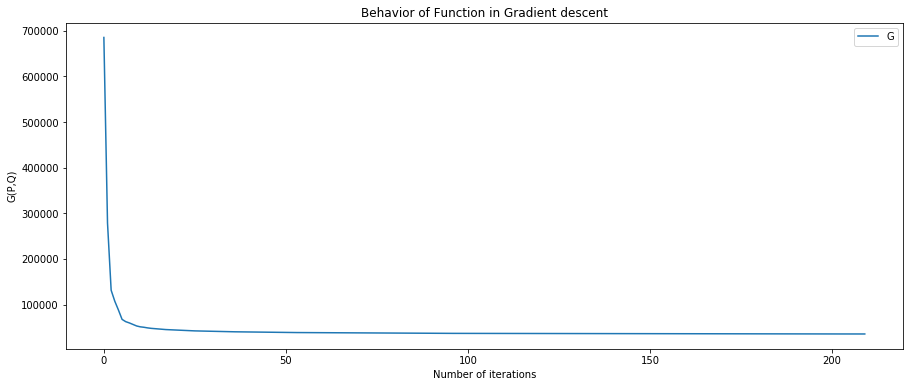

In [272]:
plt.figure(figsize=(15, 6))

plt.plot(vecpq, label = 'Gradient')
plt.axhline(y=100, color='r', label = 'Stop condition')
plt.title('Gradient descent efficiency')
plt.xlabel('Number of iterations')
plt.ylabel('Sum of Q and Ps gradients')
plt.legend()
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(vecg, label = 'G')
plt.title('Behavior of Function in Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('G(P,Q)')
plt.legend()
plt.show()

It returns two vectors that when multiplied return the expected score for every for each user for each film

### 3.3

In [17]:
scores = Q.dot(P)[300]
seen = mask[300]
maxsc=0
aux=0
for i in range(len(scores)):
    if seen[i]==0:
        if aux == 0:
            maxsc = i
            aux = 1
        elif scores[i]>scores[maxsc]:
            maxsc = i
print(f'I would recommend film number {maxsc} to viewer 300')    

I would recommend film number 312 to viewer 300
